# Feature Engineering practice

### Dataset: `IEEE-Fraud-Detection Challenge`

##### TODO list:

Задание 0: выбрать любую модель машнного обучения и зафиксировать любой тип валидации. Обучить базовую модель и зафиксировать базовое качество модели. В каждом следующем задании нужно будет обучить выбранную модель и оценивать ее качество на зафиксированной схеме валидации. После каждого задания, требуется сделать вывод о достигаемом качестве модели, по сравнению с качестом из предыдущего шага.

Задание 1: признак TransactionDT - это смещение в секундах относительно базовой даты. Базовая дата - 2017-12-01, преобразовать признак TransactionDT в datetime, прибавив к базовой дате исходное значение признака. Из полученного признака выделить год, месяц, день недели, час, день.

Задание 2: сгруппировать данные по card1 и посчитать среднюю сумму транзакции. Добавить в качестве признака в набор данных. Посчитать разницу между суммой транзакцией пользователя и средней суммой транзакции по данному типу card1. Построить отношение этих признаков. Повторить процедуру для всех card.

Задание 3: преобразовать признаки card_1 - card_6 с помощью Frequency Encoding;

Задание 4: преобразовать признак TransactionAmt в логариф признака, выделить дробную часть и целую часть в отдельные признаки.

Задание 5: для числовых признаков построить PCA-признаки, добавить их к основной части датасета.

Задание 6: использовать критерий отбора признаков на основе перестановок для отбора признаков, которые положительно влияют на перформанс модели. Переобучить модель и сделать выводы о полученном качестве алгоритма.

Задание 7: (опциональное) испольовать SHAP для оценки важности признаков. Использовать SHAP для отбора признаков, проанализировать поведение модели на одном (любом) примере, посмотреть какой вклад каждый признак вносит в итоговый прогно. Проанализировать резульаты.

In [1]:
##############
# Import libs
##############

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
import catboost as catb
import xgboost as xgb
import missingno as msno
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm
import shap

from utils.estimators import evaluate_model, fit_catboost
from utils.BuildDataset import encode_labels
from utils.feature_estimators import calculate_feature_separating_ability, calculate_permutation_importance

In [2]:
pd.set_option("max.columns", None)

In [3]:
############
# Data load
############


TRAIN_DATA_PATH = 'data/assignment_train.csv'
TEST_DATA_PATH = 'data/assignment_test.csv'


train = pd.read_csv(TRAIN_DATA_PATH)
test = pd.read_csv(TEST_DATA_PATH)

In [4]:
###########
# Settings
###########
seed = 42
np.random.seed(seed)
discret_limit = 25

ID = 'TransactionID'
DATE = 'TransactionDT'
TARGET = 'isFraud' # Target

CAT_FEATS = train.select_dtypes(include='object').columns  # Categorical
ALL_NUMERICAL_FEATS = train.select_dtypes(include=[np.number]).columns # Numerical + Target
NUMERICAL_FEATS = ALL_NUMERICAL_FEATS.drop([TARGET, ID, DATE]) # Numerical only

# Discrete feature among numerical
DISCRETE_FEATS = [feature for feature in NUMERICAL_FEATS if len(train[feature].unique()) < discret_limit]

print(f"Categorical Features Count: {len(CAT_FEATS)}")
print(f"Numerical Features Count: {len(NUMERICAL_FEATS)}")
print(f"Discrete Features of Numerical Count: {len(DISCRETE_FEATS)}")
print(f"\nTotal Features: {len(train.columns)-1}")

Categorical Features Count: 14
Numerical Features Count: 377
Discrete Features of Numerical Count: 219

Total Features: 393


In [5]:
# Apply Label encoder to all cat feats

train = encode_labels(train)
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,4,13926,NaN,150.0,1,142.0,1,315.0,87.0,19.0,NaN,34,33,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,0,1,1,2,0,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,4,2755,404.0,150.0,2,102.0,1,325.0,87.0,NaN,NaN,16,33,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,1,2,2,0,1,1,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,

# 0. Baseline fixing

Baseline valid score = 0.892402

Train CV-score: 0.8698 std: +/- 0.011

In [7]:
X = train.drop(TARGET, axis=1)
y = train[TARGET]

X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                      y,
                                                      test_size= 0.3,
                                                      stratify=y)

cb_params_1000 = {
    "n_estimators": 1000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 25,
    "verbose": 100,
    "max_depth": 10,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": seed
}

baseline_catb_model = fit_catboost(
            X_train, y_train, cb_params_1000, None, X_valid, y_valid)

evaluate_model(baseline_catb_model, X_train, y_train, X_valid, y_valid)

0:	test: 0.6055469	best: 0.6055469 (0)	total: 343ms	remaining: 5m 42s
100:	test: 0.8289584	best: 0.8289584 (100)	total: 23.3s	remaining: 3m 27s
200:	test: 0.8596965	best: 0.8597309 (198)	total: 44.7s	remaining: 2m 57s
300:	test: 0.8696296	best: 0.8696296 (300)	total: 1m 5s	remaining: 2m 32s
400:	test: 0.8764056	best: 0.8764056 (400)	total: 1m 29s	remaining: 2m 13s
500:	test: 0.8819947	best: 0.8819947 (500)	total: 1m 49s	remaining: 1m 48s
600:	test: 0.8865737	best: 0.8865737 (600)	total: 2m 11s	remaining: 1m 27s
700:	test: 0.8899857	best: 0.8899857 (700)	total: 2m 34s	remaining: 1m 6s
800:	test: 0.8928035	best: 0.8928035 (800)	total: 2m 58s	remaining: 44.4s
900:	test: 0.8955245	best: 0.8955245 (900)	total: 3m 22s	remaining: 22.3s
999:	test: 0.8978502	best: 0.8978502 (999)	total: 3m 47s	remaining: 0us

bestTest = 0.8978501894
bestIteration = 999

score = 0.89785
score = 0.892402


### Cross eval

In [21]:
cv = cross_val_score(
    estimator=baseline_catb_model,
    X=train[TRAINABLE_FEATS],
    y=train[TARGET],
    scoring="roc_auc",
    cv=3,
)

print(f"CV-result: {round(np.mean(cv), 4)} +/- {round(np.std(cv), 3)}")

0:	total: 252ms	remaining: 4m 11s
50:	total: 11.5s	remaining: 3m 34s
100:	total: 22.9s	remaining: 3m 24s
150:	total: 34.6s	remaining: 3m 14s
200:	total: 46s	remaining: 3m 2s
250:	total: 57.8s	remaining: 2m 52s
300:	total: 1m 9s	remaining: 2m 40s
350:	total: 1m 20s	remaining: 2m 29s
400:	total: 1m 31s	remaining: 2m 17s
450:	total: 1m 43s	remaining: 2m 6s
500:	total: 1m 54s	remaining: 1m 54s
550:	total: 2m 6s	remaining: 1m 42s
600:	total: 2m 18s	remaining: 1m 31s
650:	total: 2m 30s	remaining: 1m 20s
700:	total: 2m 42s	remaining: 1m 9s
750:	total: 2m 54s	remaining: 57.7s
800:	total: 3m 5s	remaining: 46.1s
850:	total: 3m 15s	remaining: 34.2s
900:	total: 3m 26s	remaining: 22.7s
950:	total: 3m 37s	remaining: 11.2s
999:	total: 3m 48s	remaining: 0us
0:	total: 192ms	remaining: 3m 11s
50:	total: 10.9s	remaining: 3m 22s
100:	total: 21.9s	remaining: 3m 14s
150:	total: 33.8s	remaining: 3m 9s
200:	total: 43.4s	remaining: 2m 52s
250:	total: 53.3s	remaining: 2m 39s
300:	total: 1m 3s	remaining: 2m 27s


# 1. `TransationDT`

Задание 1: признак TransactionDT - это смещение в секундах относительно базовой даты. Базовая дата - 2017-12-01, преобразовать признак TransactionDT в datetime, прибавив к базовой дате исходное значение признака. Из полученного признака выделить год, месяц, день недели, час, день.

In [8]:
base_date = pd.to_datetime('2017-12-01')
train[DATE] = pd.to_datetime(train[DATE], unit='s', origin=base_date)

In [9]:
train[DATE + '_Y'] = train[DATE].dt.year
train[DATE + '_M'] = train[DATE].dt.month
train[DATE + '_WD'] = train[DATE].dt.weekday
train[DATE + '_H'] = train[DATE].dt.hour
train[DATE + '_D'] = train[DATE].dt.day

train.iloc[:, -5:].head()

,TransactionDT_Y,TransactionDT_M,TransactionDT_WD,TransactionDT_H,TransactionDT_D
0,2017,12,5,0,2
1,2017,12,5,0,2
2,2017,12,5,0,2
3,2017,12,5,0,2
4,2017,12,5,0,2


In [10]:
# Обратное преобразование в timestamp
train[DATE] = (train[DATE].astype('int64') / 10**9).astype('int64')

In [11]:
X = train.drop(TARGET, axis=1)
y = train[TARGET]

X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                      y,
                                                      test_size= 0.3,
                                                      stratify=y)

fe1_catb_model = fit_catboost(
            X_train, y_train, cb_params_1000, None, X_valid, y_valid)

evaluate_model(fe1_catb_model, X_train, y_train, X_valid, y_valid)

0:	test: 0.5591439	best: 0.5591439 (0)	total: 234ms	remaining: 3m 53s
100:	test: 0.8320649	best: 0.8321304 (96)	total: 24.3s	remaining: 3m 36s
200:	test: 0.8632937	best: 0.8632937 (200)	total: 46.5s	remaining: 3m 4s
300:	test: 0.8709651	best: 0.8709651 (300)	total: 1m 10s	remaining: 2m 44s
400:	test: 0.8787398	best: 0.8787398 (400)	total: 1m 35s	remaining: 2m 22s
500:	test: 0.8851739	best: 0.8851739 (500)	total: 2m	remaining: 2m
600:	test: 0.8897423	best: 0.8897479 (598)	total: 2m 25s	remaining: 1m 36s
700:	test: 0.8933311	best: 0.8933311 (700)	total: 2m 51s	remaining: 1m 12s
800:	test: 0.8963708	best: 0.8963708 (800)	total: 3m 15s	remaining: 48.5s
900:	test: 0.8990386	best: 0.8990386 (900)	total: 3m 39s	remaining: 24.1s
999:	test: 0.9010255	best: 0.9010255 (999)	total: 4m 4s	remaining: 0us

bestTest = 0.9010255197
bestIteration = 999

score = 0.901026
score = 0.883342


На первой генерации влияние изменений неразличимо: разница между метриками меньше стандартного отклонения, показанного на кросс-валидации

`0.892402 - 0.883342 < 0.011` 

# 2. Mean transaction amount on `card` fields

Задание 2: сгруппировать данные по card1 и посчитать среднюю сумму транзакции. Добавить в качестве признака в набор данных. Посчитать разницу между суммой транзакцией пользователя и средней суммой транзакции по данному типу card1. Построить отношение этих признаков. Повторить процедуру для всех card.


In [12]:
value_col = "TransactionAmt"
card_cats = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']

In [13]:
for c_field in card_cats:
    new_feat_name_1 = c_field + "_mean_Amt"
    mean_transaction_amt_by_card = train.groupby(c_field, as_index=False)[value_col].mean().rename(columns={value_col: new_feat_name_1})

    train = train.merge(mean_transaction_amt_by_card, how="left", on=c_field)
    new_feat_name_2 = "mean_" + value_col + "_diff_by_" + c_field

    train[new_feat_name_2] = train[value_col] - train[new_feat_name_1]
    

In [14]:
train.iloc[:, -len(card_cats)*2:]

,card1_mean_Amt,mean_TransactionAmt_diff_by_card1,card2_mean_Amt,mean_TransactionAmt_diff_by_card2,card3_mean_Amt,mean_TransactionAmt_diff_by_card3,card4_mean_Amt,mean_TransactionAmt_diff_by_card4,card5_mean_Amt,mean_TransactionAmt_diff_by_card5,card6_mean_Amt,mean_TransactionAmt_diff_by_card6
0,92.125000,-23.625000,NaN,NaN,136.701195,-68.201195,211.559924,-143.059924,112.302778,-43.802778,165.657609,-97.157609
1,274.070800,-245.070800,189.650784,-160.650784,136.701195,-107.701195,124.734717,-95.734717,201.500817,-172.500817,165.657609,-136.657609
2,94.948551,-35.948551,126.992926,-67.992926,136.701195,-77.701195,126.812814,-67.812814,92.291992,-33.291992,110.833585,-51.833585
3,121.151405,-71.151405,131.551017,-81.551017,136.701195,-86.701195,124.734717,-74.734717,116.145447,-66.145447,110.833585,-60.833585
4,50.000000,0.000000,182.076024,-132.076024,136.701195,-86.701195,124.734717,-74.734717,201.500817,-151.500817,165.657609,-115.657609
...,...,...,...,...,...,...,...,...,...,...,...,...
49996,169.101924,30.898076,182.076024,17.923976,136.701195,63.298805,126.812814,73.187186,131.573350,68.426650,165.657609,34.342391
49997,214.917527,433.502473,193.233122,455.186878,136.701195,511.718805,126.812814,521.607186,212.671011,435.748989,165.657609,482.762391
49998,76.071250,-54.850250,114.759857,-93.538857,59.520900,-38.299900,124.734717,-103.513717,92.291992,-71.070992,110.833585,-89.612585
49999,217.035365,-92.035365,153.975522,-28.975522,136.701195,-11.701195,211.559924,-86.559924,201.500817,-76.500817,165.657609,-40.657609


In [15]:
X = train.drop(TARGET, axis=1)
y = train[TARGET]

X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                      y,
                                                      test_size= 0.3,
                                                      stratify=y)

fe2_catb_model = fit_catboost(
            X_train, y_train, cb_params_1000, None, X_valid, y_valid)

evaluate_model(fe2_catb_model, X_train, y_train, X_valid, y_valid)

0:	test: 0.6610720	best: 0.6610720 (0)	total: 275ms	remaining: 4m 34s
100:	test: 0.8397751	best: 0.8397751 (100)	total: 25.2s	remaining: 3m 44s
200:	test: 0.8665380	best: 0.8665380 (200)	total: 51.3s	remaining: 3m 23s
300:	test: 0.8761856	best: 0.8761856 (300)	total: 1m 17s	remaining: 3m
400:	test: 0.8825468	best: 0.8825468 (400)	total: 1m 43s	remaining: 2m 34s
500:	test: 0.8885301	best: 0.8885302 (499)	total: 2m 9s	remaining: 2m 8s
600:	test: 0.8938358	best: 0.8938358 (600)	total: 2m 34s	remaining: 1m 42s
700:	test: 0.8972686	best: 0.8972686 (700)	total: 3m	remaining: 1m 16s
800:	test: 0.9000711	best: 0.9000711 (800)	total: 3m 25s	remaining: 51s
900:	test: 0.9026744	best: 0.9026744 (900)	total: 3m 50s	remaining: 25.3s
999:	test: 0.9045229	best: 0.9045229 (999)	total: 4m 16s	remaining: 0us

bestTest = 0.9045229461
bestIteration = 999

score = 0.904523
score = 0.887976


In [40]:
(0.883342 - 0.887976)  > 0.011, (0.887976 - 0.892402) > 0.011

(False, False)

Добавление 6 новых категорий также не позволяют с уверенностью судить об улучшении/ухудшении качества модели

# 3. Frequency Encoding processing

Задание 3: преобразовать признаки card_1 - card_6 с помощью Frequency Encoding;

In [16]:
card_cats = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']

for cat in card_cats:
    freq_encoder = train[cat].value_counts(normalize=True)
    train[cat + "_freq_enc"] = train[cat].map(freq_encoder)

In [17]:
train.iloc[:, -6:].head()

,card1_freq_enc,card2_freq_enc,card3_freq_enc,card4_freq_enc,card5_freq_enc,card6_freq_enc
0,0.00008,NaN,0.901396,0.013080,0.000362,0.315714
1,0.00150,0.007504,0.901396,0.313914,0.055138,0.315714
2,0.00138,0.060583,0.901396,0.651227,0.089017,0.684106
3,0.00726,0.010770,0.901396,0.313914,0.038922,0.684106
4,0.00002,0.032513,0.901396,0.313914,0.055138,0.315714


In [18]:
X = train.drop(TARGET, axis=1)
y = train[TARGET]

X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                      y,
                                                      test_size= 0.3,
                                                      stratify=y)

fe3_catb_model = fit_catboost(
            X_train, y_train, cb_params_1000, None, X_valid, y_valid)

evaluate_model(fe3_catb_model, X_train, y_train, X_valid, y_valid)

0:	test: 0.6063705	best: 0.6063705 (0)	total: 286ms	remaining: 4m 45s
100:	test: 0.8470739	best: 0.8470739 (100)	total: 25.6s	remaining: 3m 47s
200:	test: 0.8726166	best: 0.8726166 (200)	total: 52.1s	remaining: 3m 27s
300:	test: 0.8794034	best: 0.8794034 (300)	total: 1m 18s	remaining: 3m 1s
400:	test: 0.8855154	best: 0.8855154 (400)	total: 1m 42s	remaining: 2m 33s
500:	test: 0.8907696	best: 0.8907696 (500)	total: 2m 7s	remaining: 2m 7s
600:	test: 0.8965982	best: 0.8965982 (600)	total: 2m 32s	remaining: 1m 41s
700:	test: 0.9007672	best: 0.9007672 (700)	total: 2m 58s	remaining: 1m 16s
800:	test: 0.9037903	best: 0.9037903 (800)	total: 3m 24s	remaining: 50.9s
900:	test: 0.9066320	best: 0.9066320 (900)	total: 3m 50s	remaining: 25.4s
999:	test: 0.9090032	best: 0.9090032 (999)	total: 4m 15s	remaining: 0us

bestTest = 0.9090031687
bestIteration = 999

score = 0.909003
score = 0.879851


Генерация частотных признаков показала дальнешее снижение качества метрики, которое можно считать статистически значимым относительно первых двух результатов

# 4. `TransactionAmt` processing

Задание 4: преобразовать признак TransactionAmt в логарифм признака, выделить дробную часть и целую часть в отдельные признаки.

In [19]:
value_col = "TransactionAmt"

In [20]:
train[value_col]

0         68.500
1         29.000
2         59.000
3         50.000
4         50.000
          ...   
49996    200.000
49997    648.420
49998     21.221
49999    125.000
50000    453.750
Name: TransactionAmt, Length: 50001, dtype: float64

In [21]:
train['Log_' + value_col] = np.log(train[value_col])
train['LogFloor_' + value_col] = train[value_col].apply(lambda x: math.floor(np.log(x)))
train['LogRemainder_' + value_col] = train['Log_' + value_col] - train['LogFloor_' + value_col]

train.iloc[:, -3:]

,Log_TransactionAmt,LogFloor_TransactionAmt,LogRemainder_TransactionAmt
0,4.226834,4,0.226834
1,3.367296,3,0.367296
2,4.077537,4,0.077537
3,3.912023,3,0.912023
4,3.912023,3,0.912023
...,...,...,...
49996,5.298317,5,0.298317
49997,6.474539,6,0.474539
49998,3.054991,3,0.054991
49999,4.828314,4,0.828314


In [22]:
X = train.drop(TARGET, axis=1)
y = train[TARGET]

X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                      y,
                                                      test_size= 0.3,
                                                      stratify=y)

fe4_catb_model = fit_catboost(
            X_train, y_train, cb_params_1000, None, X_valid, y_valid)

evaluate_model(fe4_catb_model, X_train, y_train, X_valid, y_valid)

0:	test: 0.6620313	best: 0.6620313 (0)	total: 277ms	remaining: 4m 36s
100:	test: 0.8428209	best: 0.8428209 (100)	total: 25.9s	remaining: 3m 50s
200:	test: 0.8689856	best: 0.8689856 (200)	total: 51.3s	remaining: 3m 24s
300:	test: 0.8785900	best: 0.8785900 (300)	total: 1m 16s	remaining: 2m 57s
400:	test: 0.8832022	best: 0.8832022 (400)	total: 1m 41s	remaining: 2m 31s
500:	test: 0.8853119	best: 0.8853119 (500)	total: 2m 6s	remaining: 2m 5s
600:	test: 0.8903636	best: 0.8903636 (600)	total: 2m 31s	remaining: 1m 40s
700:	test: 0.8954641	best: 0.8954641 (700)	total: 2m 56s	remaining: 1m 15s
800:	test: 0.8995752	best: 0.8995752 (800)	total: 3m 21s	remaining: 50.2s
900:	test: 0.9022332	best: 0.9022332 (900)	total: 3m 45s	remaining: 24.8s
999:	test: 0.9044624	best: 0.9044624 (999)	total: 4m 8s	remaining: 0us

bestTest = 0.904462416
bestIteration = 999

score = 0.904462
score = 0.885366


# 5. PCA feature generation

Задание 5: для числовых признаков построить PCA-признаки, добавить их к основной части датасета.


In [23]:
pca = PCA(n_components = 4)
scalar = StandardScaler()

# Fit the scaler to the features and transform
X_std = scalar.fit_transform(train[NUMERICAL_FEATS].apply(lambda x: x.fillna(x.mean())))

# Fit the PCA and transform the data
X_std_pca = pca.fit_transform(X_std)

In [24]:
X_std_pca_df = pd.DataFrame(X_std_pca, columns = ['PCA_c1', 'PCA_c2', 'PCA_c3', 'PCA_c4'])
train[['PCA_c1', 'PCA_c2', 'PCA_c3', 'PCA_c4']] = X_std_pca_df

In [25]:
train.iloc[:,-4:]

,PCA_c1,PCA_c2,PCA_c3,PCA_c4
0,-1.789642,0.937267,-0.175511,-0.324118
1,-1.179575,0.461747,-0.504518,-0.507730
2,-2.309204,1.236732,-0.140848,-0.362041
3,-1.411033,3.263597,6.646088,6.877646
4,-1.947692,-2.878286,-3.666599,3.494280
...,...,...,...,...
49996,-0.311971,-0.793235,0.224503,-5.040555
49997,-2.194475,1.108327,-0.423682,-0.830600
49998,22.156300,-9.759308,3.917315,0.980738
49999,-0.259959,-0.823821,0.228844,-5.056054


In [26]:
X = train.drop(TARGET, axis=1)
y = train[TARGET]

X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                      y,
                                                      test_size= 0.3,
                                                      stratify=y)

fe5_catb_model = fit_catboost(
            X_train, y_train, cb_params_1000, None, X_valid, y_valid)

evaluate_model(fe5_catb_model, X_train, y_train, X_valid, y_valid)

0:	test: 0.6568366	best: 0.6568366 (0)	total: 248ms	remaining: 4m 8s
100:	test: 0.8512929	best: 0.8513556 (99)	total: 23.8s	remaining: 3m 32s
200:	test: 0.8740063	best: 0.8740496 (199)	total: 47.7s	remaining: 3m 9s
300:	test: 0.8826490	best: 0.8826490 (300)	total: 1m 12s	remaining: 2m 48s
400:	test: 0.8859552	best: 0.8859552 (400)	total: 1m 37s	remaining: 2m 25s
500:	test: 0.8877553	best: 0.8877553 (500)	total: 2m 3s	remaining: 2m 2s
600:	test: 0.8946014	best: 0.8946014 (600)	total: 2m 30s	remaining: 1m 39s
700:	test: 0.8989756	best: 0.8989756 (700)	total: 2m 56s	remaining: 1m 15s
800:	test: 0.9021877	best: 0.9021877 (800)	total: 3m 23s	remaining: 50.5s
900:	test: 0.9046752	best: 0.9046752 (900)	total: 3m 46s	remaining: 24.9s
999:	test: 0.9059841	best: 0.9059841 (999)	total: 4m 11s	remaining: 0us

bestTest = 0.9059840791
bestIteration = 999

score = 0.905984
score = 0.875381


Можно с уверенностью сказать, что признаки на основе использованного PCA-разложения ухудшают метрику

# 6. Permutation importances

Задание 6: использовать критерий отбора признаков на основе перестановок для отбора признаков, которые положительно влияют на перформанс модели. Переобучить модель и сделать выводы о полученном качестве алгоритма.


In [38]:
perm_importance = calculate_permutation_importance(
    estimator=fe5_catb_model, metric=roc_auc_score, x_valid=X_valid, y_valid=y_valid)

100%|████████████████████████████████████████████████████████████████████████████████| 423/423 [01:38<00:00,  4.28it/s]


In [45]:
perm_importance

C1                                   0.022079
card2_freq_enc                       0.018428
C12                                  0.014708
V317                                 0.013514
V294                                 0.008600
                                       ...   
V57                                 -0.001229
M2                                  -0.001229
V64                                 -0.001229
mean_TransactionAmt_diff_by_card3   -0.001263
V66                                 -0.001263
Length: 423, dtype: float64

Отберем первые 200 признаков с неотрицательным PI-влиянием на модель, сравним результат

In [55]:
perm_importance[:200]

C1                0.022079
card2_freq_enc    0.018428
C12               0.014708
V317              0.013514
V294              0.008600
                    ...   
V159              0.000000
V265              0.000000
V274              0.000000
V266              0.000000
V267              0.000000
Length: 250, dtype: float64

In [93]:
PI_FEATS = perm_importance[:200].index

In [94]:
X = train[PI_FEATS]
y = train[TARGET]

X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                      y,
                                                      test_size= 0.3,
                                                      stratify=y)

fe6_catb_model = fit_catboost(
            X_train, y_train, cb_params_1000, None, X_valid, y_valid)

evaluate_model(fe6_catb_model, X_train, y_train, X_valid, y_valid)

0:	test: 0.6376190	best: 0.6376190 (0)	total: 85.2ms	remaining: 1m 25s
100:	test: 0.8413395	best: 0.8413395 (100)	total: 7.83s	remaining: 1m 9s
200:	test: 0.8667443	best: 0.8667443 (200)	total: 16s	remaining: 1m 3s
300:	test: 0.8759355	best: 0.8759355 (300)	total: 24.3s	remaining: 56.5s
400:	test: 0.8817047	best: 0.8817047 (400)	total: 32.6s	remaining: 48.6s
500:	test: 0.8875474	best: 0.8875474 (500)	total: 40.8s	remaining: 40.7s
600:	test: 0.8920869	best: 0.8920869 (600)	total: 49.3s	remaining: 32.7s
700:	test: 0.8964171	best: 0.8964171 (700)	total: 58.2s	remaining: 24.8s
800:	test: 0.8999456	best: 0.8999456 (800)	total: 1m 6s	remaining: 16.6s
900:	test: 0.9031964	best: 0.9031964 (900)	total: 1m 15s	remaining: 8.33s
999:	test: 0.9054168	best: 0.9054168 (999)	total: 1m 24s	remaining: 0us

bestTest = 0.905416771
bestIteration = 999

score = 0.905417
score = 0.899999


Исключение более половины малозначимых признаков положительно сказалось на работе модели. Результат превысил Baseline

# 7. [SHAP](https://github.com/slundberg/shap) importances

Задание 7: (опциональное) испольовать SHAP для оценки важности признаков. Использовать SHAP для отбора признаков, проанализировать поведение модели на одном (любом) примере, посмотреть какой вклад каждый признак вносит в итоговый прогноз. Проанализировать резульаты.

In [58]:
X = train.drop(TARGET, axis=1)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


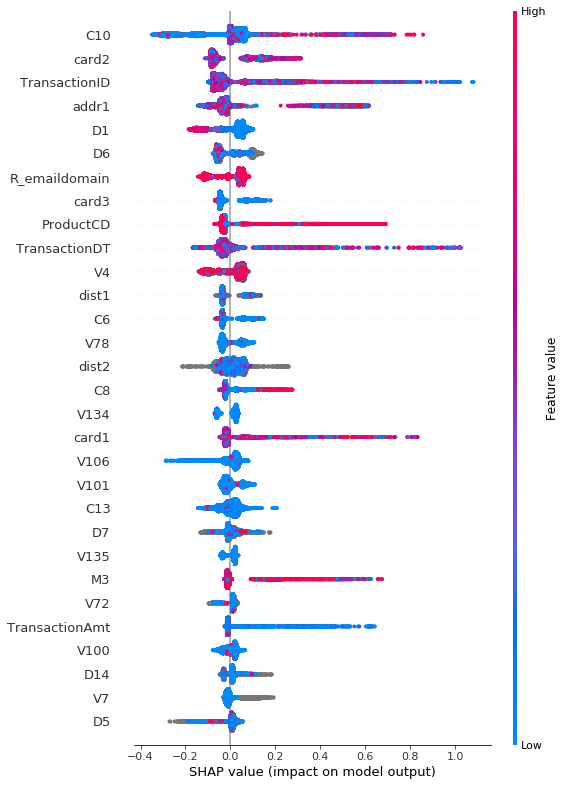

In [60]:
explainer = shap.TreeExplainer(fe6_catb_model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, max_display=30)

In [116]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(updated_catb_model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [67]:
vals = np.abs(shap_values).mean(0)
shap_feature_importance = pd.DataFrame(list(zip(train.columns,vals)),columns=['feature','shap_values'])
shap_feature_importance.sort_values(by=['shap_values'],ascending=False,inplace=True)

shap_feature_importance.head(20)

,feature,shap_values
25,C9,0.112608
5,card1,0.095843
0,TransactionID,0.088664
10,card6,0.063380
30,C14,0.061524
35,D5,0.060970
15,P_emaildomain,0.059215
6,card2,0.059167
3,TransactionAmt,0.053338
1,isFraud,0.053123


In [95]:
shap_feature_importance[:200]

,feature,shap_values
25,C9,0.112608
5,card1,0.095843
0,TransactionID,0.088664
10,card6,0.063380
30,C14,0.061524
...,...,...
173,V119,0.000786
186,V132,0.000776
171,V117,0.000768
172,V118,0.000761


In [98]:
SHAP_FEATS = shap_feature_importance["feature"].values.tolist()[:200+1]
SHAP_FEATS.remove(TARGET)

In [99]:
X = train.drop(TARGET, axis=1)[SHAP_FEATS]
y = train[TARGET]

X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                      y,
                                                      test_size= 0.3,
                                                      stratify=y)

fe7_catb_model = fit_catboost(
            X_train, y_train, cb_params_1000, None, X_valid, y_valid)

evaluate_model(fe7_catb_model, X_train, y_train, X_valid, y_valid)

0:	test: 0.6923114	best: 0.6923114 (0)	total: 79.1ms	remaining: 1m 19s
100:	test: 0.8408150	best: 0.8408150 (100)	total: 8.2s	remaining: 1m 13s
200:	test: 0.8612845	best: 0.8613336 (199)	total: 16.5s	remaining: 1m 5s
300:	test: 0.8735293	best: 0.8735293 (300)	total: 24.9s	remaining: 57.7s
400:	test: 0.8777064	best: 0.8777073 (399)	total: 33s	remaining: 49.3s
500:	test: 0.8806419	best: 0.8806419 (500)	total: 40.8s	remaining: 40.6s
600:	test: 0.8849652	best: 0.8849652 (600)	total: 48.8s	remaining: 32.4s
700:	test: 0.8909473	best: 0.8909473 (700)	total: 57.1s	remaining: 24.4s
800:	test: 0.8952953	best: 0.8952953 (800)	total: 1m 5s	remaining: 16.3s
900:	test: 0.8997233	best: 0.8997233 (900)	total: 1m 13s	remaining: 8.1s
999:	test: 0.9038977	best: 0.9038977 (999)	total: 1m 22s	remaining: 0us

bestTest = 0.9038977355
bestIteration = 999

score = 0.903898
score = 0.881537


#### Scores:

|      Model name     | Valid Score |
| ------------------- | ----------- |
| baseline_catb_model | 0.892402    |
| fe1_catb_model      | 0.883342    |
| fe2_catb_model      | 0.887976    |
| fe3_catb_model      | 0.879851    |
| fe4_catb_model      | 0.885366    |
| fe5_catb_model      | 0.875381    |
| fe6_catb_model      | 0.899999    |
| fe7_catb_model      | 0.881537    |

### Выводы:

 - В итоге удалось улучшить качество модели на порядок 1%, так что можно сказать, что Feature Engineering проведен успешно, (но всё ещё недостаточно тщательно)
 - Рейтинги отобранных групп признаков при помощи Shap, PI, AUC, довольно сильно отличаются друг от друга
 - В данном примере, признаки, отобранные по PI имеют больший вклад в качество модели, чем, отобранные в результате SHAP-анализа (в соревновании лучше всего себя показывает отбор по-AUC)